<a href="https://colab.research.google.com/github/HuzaifaAnsari0/CC-IA2/blob/main/CC_IA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd
from datetime import datetime

# === UPLOAD FILES IN COLAB ===
from google.colab import files
uploaded = files.upload()

# === LOAD FILES ===
with open("inspect_nginx.json") as f:
    inspect_data = json.load(f)

with open("snyk_nginx.json") as f:
    snyk_data = json.load(f)

# === EXTRACT FROM DOCKER INSPECT ===
docker = inspect_data[0]
image_name = docker["RepoTags"][0]
created = docker["Created"]
size_mb = round(docker["Size"] / (1024 * 1024), 2)
layers = len(docker["RootFS"]["Layers"])

# === EXTRACT FROM SNYK JSON ===
vulns = snyk_data.get("vulnerabilities", [])
severity_count = {"critical": 0, "high": 0, "medium": 0, "low": 0}
for v in vulns:
    severity = v["severity"].lower()
    if severity in severity_count:
        severity_count[severity] += 1

total_vulns = len(vulns)

# === BUILD THE DATAFRAME ROW ===
row = {
    "Image Name": image_name,
    "Created": created,
    "Size (MB)": size_mb,
    "Layers": layers,
    "Critical": severity_count["critical"],
    "High": severity_count["high"],
    "Medium": severity_count["medium"],
    "Low": severity_count["low"],
    "Total Vulnerabilities": total_vulns
}

df = pd.DataFrame([row])

# === SAVE TO CSV ===
csv_filename = "docker_image_dataset.csv"
df.to_csv(csv_filename, index=False)
files.download(csv_filename)


Saving inspect_nginx.json to inspect_nginx (1).json
Saving snyk_nginx.json to snyk_nginx (1).json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Confusion Matrix:
[[2 0]
 [0 3]]

Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00         2
        Safe       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



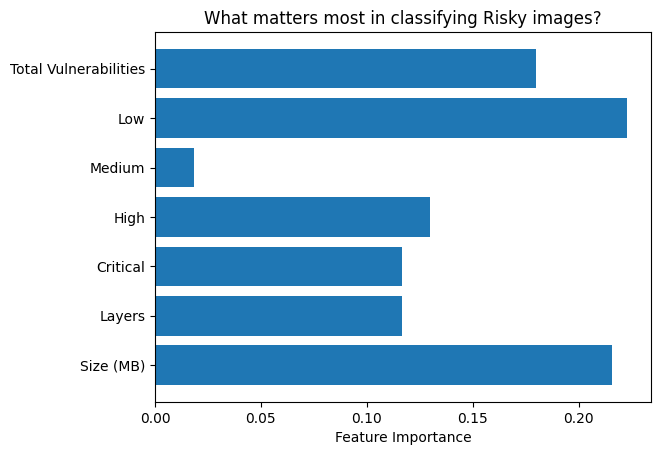

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

data = pd.read_csv(r"docker_image_dataset.csv")

data = data.dropna()

numeric_features = ['Size (MB)', 'Layers', 'Critical', 'High', 'Medium', 'Low', 'Total Vulnerabilities']
X = data[numeric_features]
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

model = pipeline.named_steps['classifier']
importances = model.feature_importances_

plt.barh(numeric_features, importances)
plt.xlabel("Feature Importance")
plt.title("What matters most in classifying Risky images?")
plt.show()